In [23]:
dataname="trg_multi"
gpuid=0


class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
nclasses=len(class_names)


# --- training params
batch_size=128
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 2
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

from albumentations import *
from albumentations.pytorch import ToTensor


import scipy

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter
from tqdm.autonotebook import tqdm

from torchsummary import summary
import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [9]:
checkpoint = torch.load("/home/ltran/trg_ltran/models/multi/multires-v0.pth", map_location=lambda storage, loc: storage)

In [11]:
from  MultiResSmallNetwork import MergeSmallNetworks
model=MergeSmallNetworks(nclasses = nclasses, outputsize = 8 ).to(device)
#model.load_state_dict(checkpoint["model_dict"])
#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data)

In [12]:
summary(model.res1,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 62, 62]             168
              ReLU-2            [-1, 6, 62, 62]               0
       BatchNorm2d-3            [-1, 6, 62, 62]              12
            Conv2d-4            [-1, 8, 30, 30]             440
              ReLU-5            [-1, 8, 30, 30]               0
       BatchNorm2d-6            [-1, 8, 30, 30]              16
            Conv2d-7            [-1, 8, 14, 14]             584
              ReLU-8            [-1, 8, 14, 14]               0
       BatchNorm2d-9            [-1, 8, 14, 14]              16
           Conv2d-10              [-1, 8, 6, 6]             584
             ReLU-11              [-1, 8, 6, 6]               0
      BatchNorm2d-12              [-1, 8, 6, 6]              16
           Conv2d-13              [-1, 8, 2, 2]             584
             ReLU-14              [-1, 

In [13]:
summary(model.res2.encoder,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 62, 62]             168
              ReLU-2            [-1, 6, 62, 62]               0
       BatchNorm2d-3            [-1, 6, 62, 62]              12
            Conv2d-4            [-1, 8, 30, 30]             440
              ReLU-5            [-1, 8, 30, 30]               0
       BatchNorm2d-6            [-1, 8, 30, 30]              16
            Conv2d-7            [-1, 8, 14, 14]             584
              ReLU-8            [-1, 8, 14, 14]               0
       BatchNorm2d-9            [-1, 8, 14, 14]              16
           Conv2d-10              [-1, 8, 6, 6]             584
             ReLU-11              [-1, 8, 6, 6]               0
      BatchNorm2d-12              [-1, 8, 6, 6]              16
           Conv2d-13              [-1, 8, 2, 2]             584
             ReLU-14              [-1, 

In [14]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgres1.shape[0]
        
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgres1=db.root.imgres1
            self.imgres2=db.root.imgres2
            
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            imgres1 = self.imgres1[index,:,:,:]
            imgres2 = self.imgres2[index,:,:,:]
            
            label = self.labels[index]
        
        
        imgres1_new = imgres1
        imgres2_new = imgres2
        
        if self.img_transform:
            #img_new = self.img_transform(image=img)['image']
            trans = self.img_transform(image=imgres1,imgres2=imgres2)
            imgres1_new = trans['image']
            imgres2_new = trans['imgres2']

        return imgres1_new, imgres2_new, label
    def __len__(self):
        return self.nitems

In [15]:
#https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb
img_transform = Compose([
        RandomScale(scale_limit=0.1,p=.9),
        PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3), 
                       border_mode=cv2.BORDER_REFLECT),
        ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        RandomContrast(p=.5, limit=(-0.2, 0.2)),
        RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        #HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        CenterCrop(patch_size,patch_size),
        ToTensor()
    ], additional_targets={'imgres2':'image'})

In [18]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"/home/ltran/trg_ltran/data/processed/{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	64000
val dataset size:	12800


Tumor


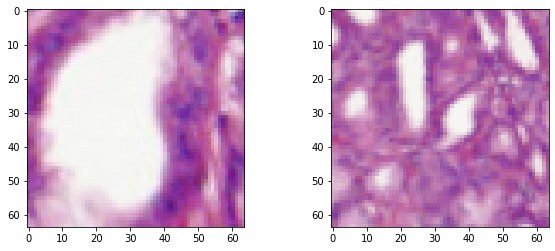

In [19]:
#visualize a single example to verify that it is correct
(imgres1,imgres2, label)=dataset["train"][0]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(imgres1.numpy(),0,-1))
ax[1].imshow(np.moveaxis(imgres2.numpy(),0,-1))


# ax[0].imshow(imgres1)
# ax[1].imshow(imgres2)


print(class_names[label])

In [20]:
imgres1.shape

torch.Size([3, 64, 64])

In [21]:
optim = torch.optim.Adam(model.parameters(), weight_decay=.001) 

In [22]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class

class_weight=dataset["train"].classsizes
print(class_weight)
#class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)
class_weight = torch.from_numpy(class_weight.max()/class_weight).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 

[[ 7500 14500  6000  3000 14500  6000  7500  5000]]
tensor([[1.9333, 1.0000, 2.4167, 4.8333, 1.0000, 2.4167, 1.9333, 2.9000]],
       device='cuda:0')


In [ ]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (Xres1, Xres2, label) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            Xres1 = Xres1.to(device)  # [Nbatch, 3, H, W]
            Xres2 = Xres2.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...num_classes)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                
                prediction = model.dualfoward(Xres1,Xres2)  # [N, Nclass]
                #prediction = model.res1(Xres1)  # [N, Nclass]
                #prediction = model.res2(Xres2)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                            shape=(nclasses, nclasses), dtype=np.int64,
                            ).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM
                    

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}


        torch.save(state, f"/home/ltran/trg_ltran/models/model-training.pth")
    else:
        print("")

In [ ]:
print(best_lost_on_test)

In [73]:

#%load_ext line_profiler
#%lprun -f trainnetwork trainnetwork()

In [ ]:
#At this stage, training is done...below are snippets to help with output generation

In [ ]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_simple_multires_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [ ]:
#grab a single image from validation set
(imgres1, imgres2, label)=dataset["val"][2]

In [ ]:
imgres2.shape

In [ ]:
#generate its output
#%%timeit
output=model.dualfoward(imgres1[None,::].to(device), imgres2[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

In [ ]:
print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(imgres1.numpy(),0,-1))
ax[1].imshow(np.moveaxis(imgres2.numpy(),0,-1))
